In [525]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

In [526]:

path = '../../../Atliq Marts Challenge'
fact_order_lines_df=pd.read_csv(path+"/fact_order_lines.csv")
# fact_orders_aggregate_df=pd.read_csv("Atliq Marts Challenge/fact_orders_aggregate.csv")

dim_date=pd.read_csv(path+"/dim_date.csv")
dim_customers=pd.read_csv(path+"/dim_customers.csv")
dim_products=pd.read_csv(path+"/dim_products.csv")
dim_targets_orders=pd.read_csv(path+"/dim_targets_orders.csv")
dim_date=pd.read_csv(path+"/dim_date.csv")
dim_date = dim_date.rename(columns={'date': 'agreed_delivery_date','mmm_yy': 'agreed_delivery_mmm_yy','week_no': 'agreed_delivery_week_num'})

In [527]:
# result =  pd.concat([fact_order_lines_df, fact_orders_aggregate_df], axis=1,join="outer")
# result =pd.merge( fact_order_lines_df, fact_orders_aggregate_df, on=["order_id", "customer_id"])
# esult =pd.merge( fact_order_lines_df, fact_orders_aggregate_df, on=["order_id", "customer_id"])
result =pd.merge( fact_order_lines_df ,dim_customers , how="outer",on=["customer_id"])
result =pd.merge( result ,dim_products , how="outer",on=["product_id"])
result =pd.merge( result ,dim_targets_orders , how="outer",on=["customer_id"])
df =pd.merge( result ,dim_date , how="outer",on=["agreed_delivery_date"])

In [528]:
df.head()

,order_id,order_placement_date,customer_id,product_id,order_qty,agreed_delivery_date,actual_delivery_date,delivery_qty,In Full,On Time,On Time In Full,customer_name,city,product_name,category,ontime_target%,infull_target%,otif_target%,agreed_delivery_mmm_yy,agreed_delivery_week_num
0,FMR32603203,01-Mar-22,789603.0,25891203.0,460.0,02-Mar-22,03-Mar-22,460.0,1.0,0.0,1.0,Info Stores,Vadodara,AM Butter 500,Dairy,92.0,75.0,69.0,Mar 22,W 10
1,FMR32401103,01-Mar-22,789401.0,25891103.0,476.0,02-Mar-22,02-Mar-22,476.0,1.0,1.0,1.0,Propel Mart,Surat,AM Milk 100,Dairy,85.0,79.0,67.0,Mar 22,W 10
2,FMR32320302,01-Mar-22,789320.0,25891203.0,347.0,02-Mar-22,02-Mar-22,347.0,1.0,1.0,1.0,Chiptec Stores,Surat,AM Butter 500,Dairy,91.0,81.0,74.0,Mar 22,W 10
3,FMR32320302,01-Mar-22,789320.0,25891302.0,54.0,02-Mar-22,02-Mar-22,54.0,1.0,1.0,1.0,Chiptec Stores,Surat,AM Ghee 150,Dairy,91.0,81.0,74.0,Mar 22,W 10
4,FMR32320202,01-Mar-22,789320.0,25891202.0,211.0,02-Mar-22,03-Mar-22,211.0,1.0,0.0,1.0,Chiptec Stores,Surat,AM Butter 250,Dairy,91.0,81.0,74.0,Mar 22,W 10


In [529]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.rename(columns=lambda x: x.replace("(", "").replace(")", ""), inplace=True)
df.rename(columns=lambda x: x.replace("%", "_percent"), inplace=True)

In [530]:
df['actual_delivery_date_formatted'] = pd.to_datetime(df['actual_delivery_date'], format='%d-%b-%y')
df = df.sort_values(by='actual_delivery_date_formatted')
# feature = ['customer_name','product_name','delivery_qty','in_full','on_time','on_time_in_full','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty']
# feature = ['customer_name','product_name','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty']
feature = ['customer_name','product_name','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty','agreed_delivery_mmm_yy','agreed_delivery_week_num']
df = df[feature]

In [531]:
df = df.drop_duplicates()
# Check for duplicated rows
duplicated_rows = df.duplicated()

# Filter the DataFrame to show duplicated rows
duplicated_df = df[duplicated_rows]

print("Duplicated Rows:")
print(duplicated_df)

Duplicated Rows:
Empty DataFrame
Columns: [customer_name, product_name, city, category, ontime_target_percent, infull_target_percent, otif_target_percent, order_qty, agreed_delivery_mmm_yy, agreed_delivery_week_num]
Index: []


In [532]:
Obj_feature = ['customer_name','product_name','city','category']
for e in Obj_feature:
    tmp = pd.get_dummies(df[e],drop_first=True)
    df.drop([e],axis=1,inplace=True)
    df = pd.concat([df,tmp],axis=1)
df.shape

(56634, 41)

In [533]:
df[['month', 'year']] = df['agreed_delivery_mmm_yy'].str.split(' ', expand=True)
df.drop(['agreed_delivery_mmm_yy'],axis=1,inplace=True)
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Replace month names with numeric values
df['month'] = df['month'].replace(month_mapping)

df[['W', 'agreed_delivery_week_no']] = df['agreed_delivery_week_num'].str.split(' ', expand=True)
df.drop(['agreed_delivery_week_num'],axis=1,inplace=True)
df.drop(['W'],axis=1,inplace=True)

In [534]:
def read_data (months,df):
    i=0
    for month in months:
        if i !=0:
            features_temp=df[df['month']==month] .loc[:, df[df['month']==month] .columns !='order_qty']
            labels_temp=df[df['month']==month] .loc[:, df[df['month']==month] .columns =='order_qty']
            features = pd.concat([features, features_temp])
            labels = pd.concat([labels, labels_temp])
        else :
            features=df[df['month']==month] .loc[:, df[df['month']==month] .columns !='order_qty']
            labels=df[df['month']==month].loc[:, df[df['month']==month] .columns =='order_qty']
        i+=1
    return features,labels


In [535]:

x_train, y_train = read_data([3,4,5,6],df)
# use data from month 9 as validation set
x_val, y_val = read_data([7],df)

# use data from month 10 as test set
x_test, y_test = read_data([8],df)


print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (37359, 39)
y_train shape: (37359, 1) 

x_val shape: (9608, 39)
y_val shape: (9608, 1) 

x_test shape: (9367, 39)
y_test shape: (9367, 1)


In [536]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37359 entries, 77 to 21839
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ontime_target_percent  37358 non-null  float64
 1   infull_target_percent  37358 non-null  float64
 2   otif_target_percent    37358 non-null  float64
 3   Atlas Stores           37359 non-null  uint8  
 4   Chiptec Stores         37359 non-null  uint8  
 5   Coolblue               37359 non-null  uint8  
 6   Elite Mart             37359 non-null  uint8  
 7   Expert Mart            37359 non-null  uint8  
 8   Expression Stores      37359 non-null  uint8  
 9   Info Stores            37359 non-null  uint8  
 10  Logic Stores           37359 non-null  uint8  
 11  Lotus Mart             37359 non-null  uint8  
 12  Propel Mart            37359 non-null  uint8  
 13  Rel Fresh              37359 non-null  uint8  
 14  Sorefoz Mart           37359 non-null  uint8  
 15  V

In [537]:
y_train

,order_qty
77,86.0
24,397.0
6,77.0
104,208.0
87,42.0
...,...
21899,84.0
22059,397.0
21971,61.0
22066,422.0


In [538]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]
    
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [539]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(41, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        print(y)
        return y.reshape(-1, 1)

In [540]:
# class FeedForwardNN(nn.Module):
#     def __init__(self, hidden_size=200):
#         super(FeedForwardNN, self).__init__()
#         self.ff1 = nn.Linear(41, hidden_size)
#         # self.do1 = nn.Dropout(p=0.3)
#         self.ff2 = nn.Linear(hidden_size, hidden_size)
#         # self.do2 = nn.Dropout(p=0.3)
#         self.ff3 = nn.Linear(hidden_size, hidden_size)
#         # self.do3 = nn.Dropout(p=0.3)
#         self.out = nn.Linear(hidden_size, 1)


#     def forward(self, x):
#         hd = F.relu(self.ff1(x))
#         # x2 = F.relu(self.do1(hd1))
#         hd = F.relu(self.ff2(hd))
#         # x3 = F.relu(self.do2(hd2))
#         y = F.relu(self.ff3(hd))
#         # y = F.relu(self.do3(hd3))
#         y = self.out(y)
#         return y.reshape(-1, 1)

In [541]:
normalizer = normalizer_std(x_train) # We will normalize everything based on x_train

train_dataset = RainfallDatasetFF(x_train.to_numpy(), y_train.to_numpy(), normalizer)
val_dataset = RainfallDatasetFF(x_val.to_numpy(), y_val.to_numpy(), normalizer)
test_dataset = RainfallDatasetFF(x_test.to_numpy(), y_test.to_numpy(), normalizer)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

(37359, 39)
(37359, 1)
(9608, 39)
(9608, 1)
(9367, 39)
(9367, 1)


In [542]:
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [543]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

In [544]:
summary(model_ff, input_size=(64, 41))

tensor([[-0.0446],
        [-0.0410],
        [-0.0564],
        [-0.0705],
        [-0.0545],
        [-0.0593],
        [-0.0689],
        [-0.0555],
        [-0.0701],
        [-0.0514],
        [-0.0757],
        [-0.0516],
        [-0.0691],
        [-0.0468],
        [-0.0656],
        [-0.0593],
        [-0.0490],
        [-0.0547],
        [-0.0696],
        [-0.0670],
        [-0.0285],
        [-0.0524],
        [-0.0678],
        [-0.0624],
        [-0.0544],
        [-0.0513],
        [-0.0498],
        [-0.0513],
        [-0.0524],
        [-0.0376],
        [-0.0481],
        [-0.0767],
        [-0.0443],
        [-0.0489],
        [-0.0561],
        [-0.0487],
        [-0.0565],
        [-0.0526],
        [-0.0545],
        [-0.0463],
        [-0.0613],
        [-0.0501],
        [-0.0567],
        [-0.0359],
        [-0.0431],
        [-0.0546],
        [-0.0566],
        [-0.0515],
        [-0.0563],
        [-0.0604],
        [-0.0610],
        [-0.0547],
        [-0.

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            [64, 1]                   --
├─Linear: 1-1                            [64, 200]                 8,400
├─Linear: 1-2                            [64, 200]                 40,200
├─Linear: 1-3                            [64, 200]                 40,200
├─Linear: 1-4                            [64, 1]                   201
Total params: 89,001
Trainable params: 89,001
Non-trainable params: 0
Total mult-adds (M): 5.70
Input size (MB): 0.01
Forward/backward pass size (MB): 0.31
Params size (MB): 0.36
Estimated Total Size (MB): 0.67

In [545]:
train_losses = []
val_losses = []
learning_rates = []

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')


print('Finished Training')

Training epoch 1...
Current LR: 0.01


  0%|          | 0/584 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x39 and 41x200)

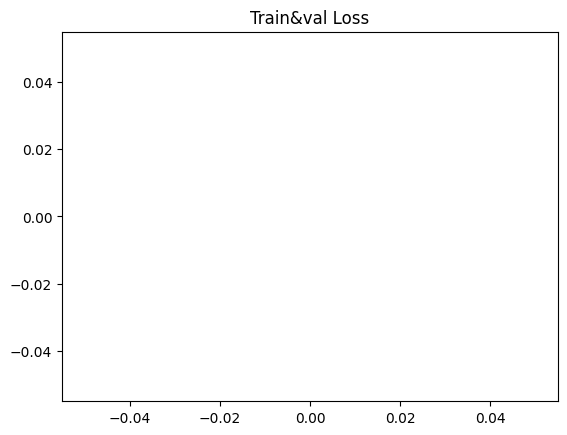

In [ ]:
x = [i + 1 for i in range(config['epochs'])]

plt.plot(x, train_losses,color = 'blue')
plt.title("Train&val Loss")
plt.plot(x, val_losses,color = 'red')

plt.show()

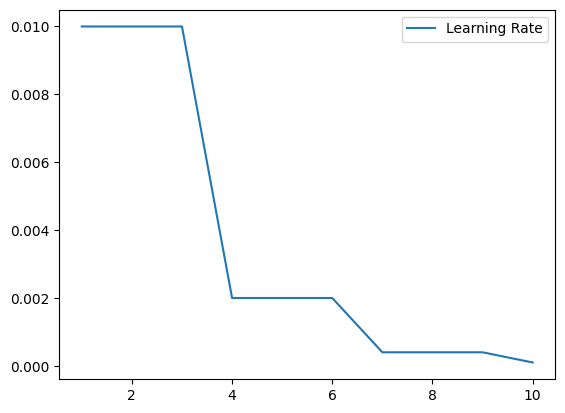

In [ ]:
plt.plot(x, learning_rates, label="Learning Rate")
plt.legend()
plt.show()